# Amplitude damping experience
#### Todo: Need to document

In [1]:
import numpy as np
import operator
from project_common import *
import matplotlib.pyplot as plt

NAME = 'RandomCircuits'
SEED = 1
SHOTS = 5000
NUM_INTERVALS = 100
QUBITS_NUM = 10
GATES_NUM = 15
CIRCUITS_NUM = 5
GATES = ['cx', 'h', 'x', 'y', 'z', 's']


In [2]:
# Creating a qobj with QUBITS_NUM qubits and random circuits.
qobj = create_basic_qobj(name=NAME, shots=SHOTS, seed=SEED)
qobj['circuits'], circuit_drawers = generate_random_circuits(QUBITS_NUM,
                                                                   GATES_NUM,
                                                                   CIRCUITS_NUM,
                                                                   GATES)

# qobj with measurements on all qubits at the end of each circuit
qobj_measurements = add_measurements(qobj)

# qobj with snapshot at the end of each circuit, and configured to output density matrix
# For running exact only (with density matrix)
qobj_snapshot = add_snapshots(qobj)


In [3]:
# Run exact simulator with amplitude damping, and Clifford simulator with relaxation.
sim_results = dict(clifford=[], exact=[])
gamma_range = np.linspace(0, 1, num=NUM_INTERVALS, dtype=float, endpoint=False)
for gamma in gamma_range:
    # Run exact simulator with amplitude damping (operator_sum)
    sim_results['exact'].append(run(qobj_measurements, gamma,
                                    EXACT_SIM_STR, set_amplitude_damping))
    
    # Run clifford simulator with relaxation
    sim_results['clifford'].append(run(qobj_measurements, gamma,
                                       CLIFFORD_SIM_STR, set_relaxation))
    

In [4]:
# Calculating frobenios norm out of exact and clifford measurements counts
results_frob = [[] for _ in range(CIRCUITS_NUM)]
for exact_res, clifford_res in zip(sim_results['exact'], sim_results['clifford']):
    for i in range(CIRCUITS_NUM):
            results_frob[i].append(metric_fro_exact_clifford(exact_res, clifford_res,
                                                                       i, QUBITS_NUM))

# Calculate maximum, minimum and average
results_max = []
results_min = []
results_avg = []
for frob_res in results_frob:
    # Max
    index, value = max(enumerate(frob_res), key=operator.itemgetter(1))
    results_max.append((gamma_range[index], value))
    
    # Min
    index, value = min(enumerate(frob_res), key=operator.itemgetter(1))
    results_min.append((gamma_range[index], value))
    
    # Average
    results_avg.append(np.mean(frob_res))

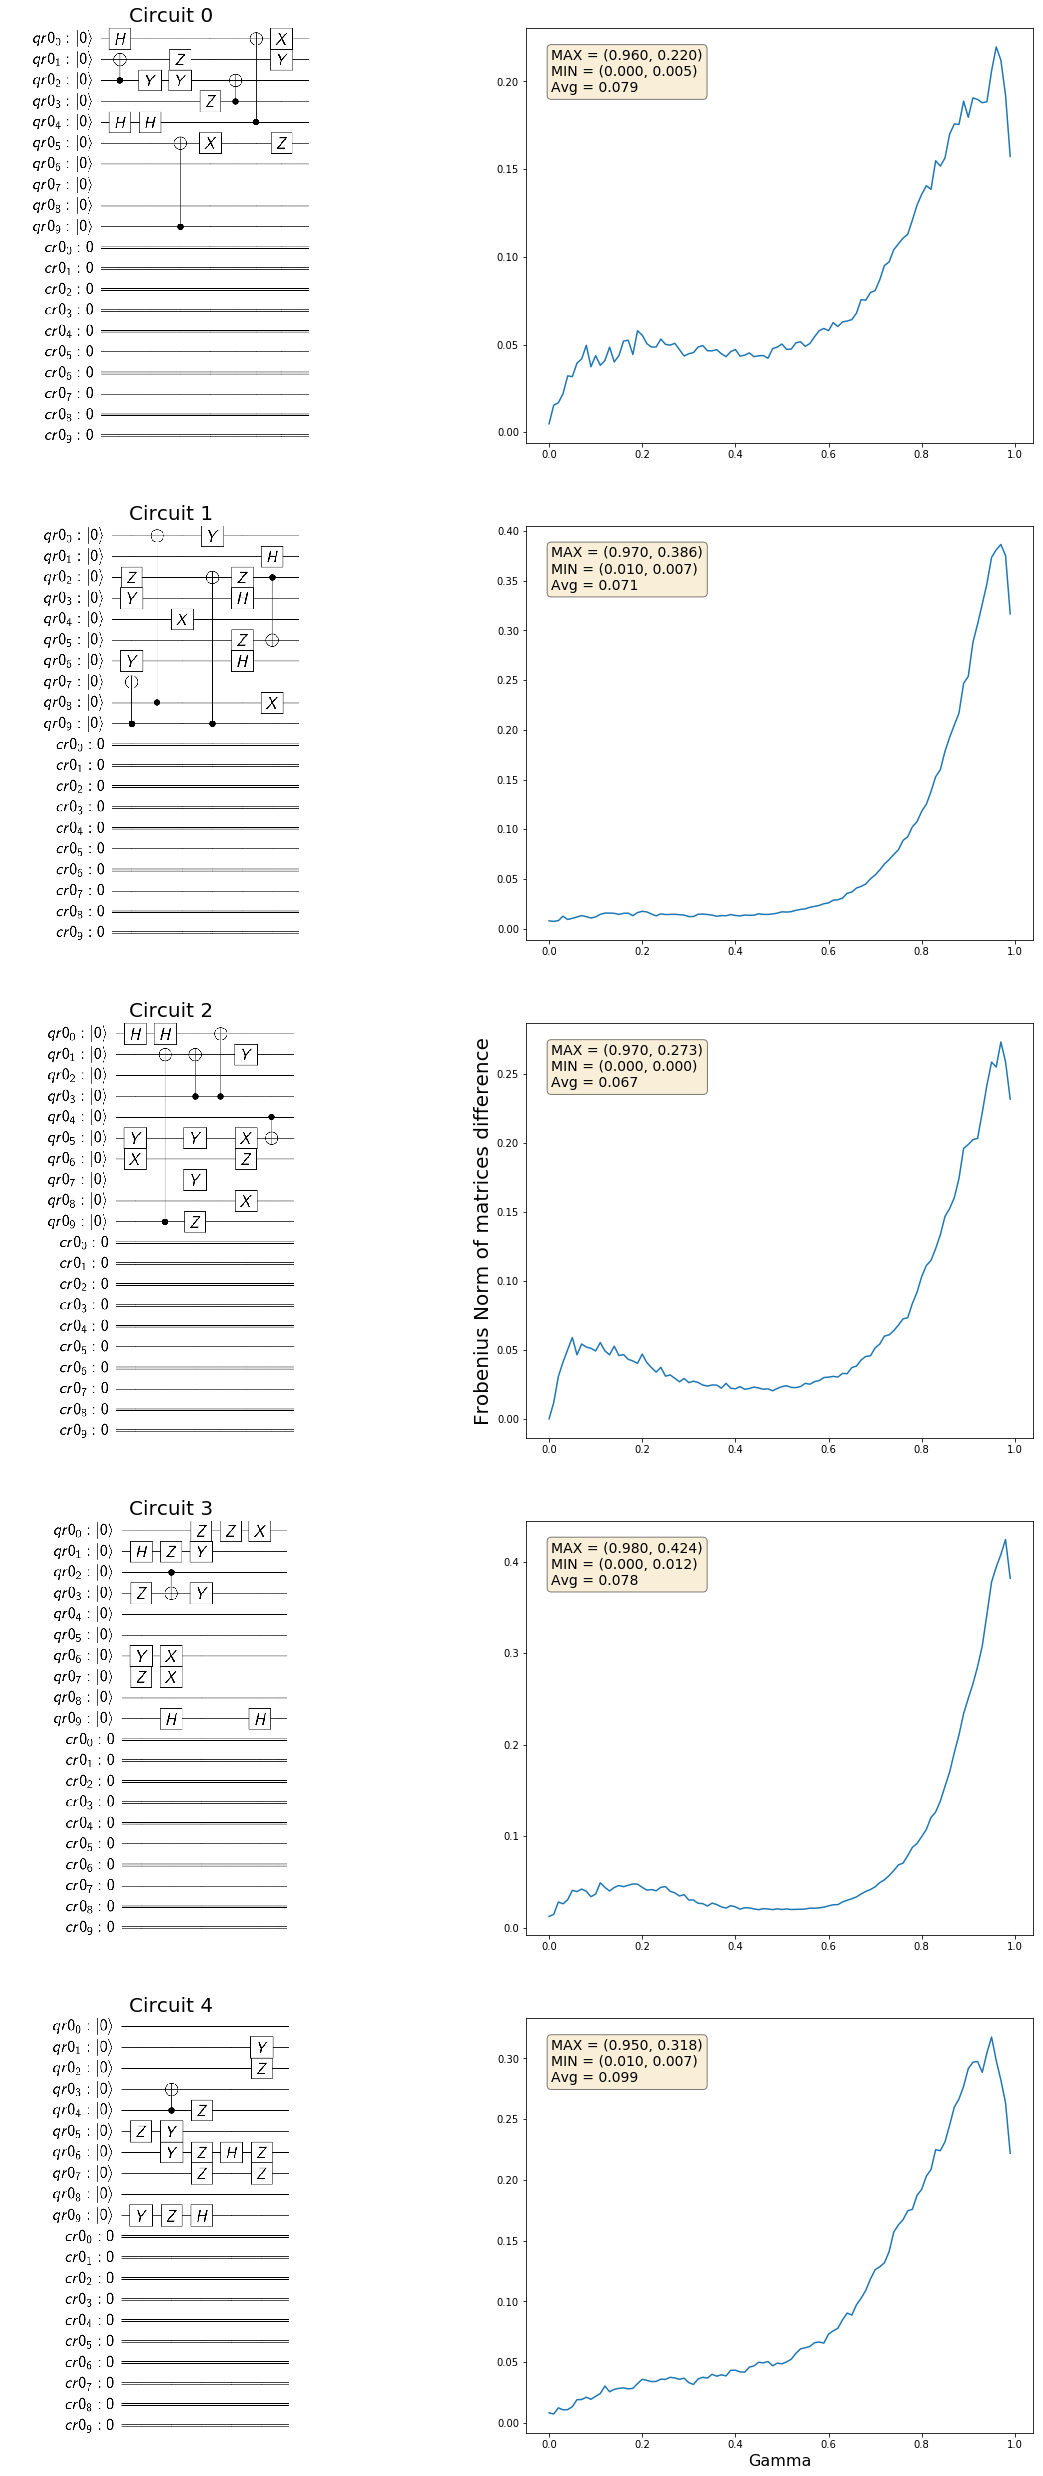

In [12]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 90]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i in range(CIRCUITS_NUM):
    textstr = 'MAX = (%.3f, %.3f)\nMIN = (%.3f, %.3f)\nAvg = %.3f' % (
        *results_max[i], *results_min[i], results_avg[i])
    ax = plt.subplot(len(circuit_drawers)*2, 2, i*2+1)
    ax.set_title('Circuit %d' % i, fontsize=20)
    plt.imshow(circuit_drawers[i])
    plt.axis('off')
    ax = plt.subplot(len(circuit_drawers)*2, 2, i*2+2)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    plt.plot(gamma_range, results_frob[i])
    if i == CIRCUITS_NUM//2:
        plt.ylabel('Frobenius Norm of matrices difference', fontsize=20)
plt.xlabel('Gamma', fontsize=16)
pass